# Running a Polymer Welding Workflow with Hoomd-Organics

## Overview:
In this tutorial, we'll show a workflow that involves multiple steps of initializing a system and running simulations. In this case, part of initializing a system invovles running a simulation where the final structure of the simulaton serves as the input for the next round of system building and simulation.

**Specifically, the goal of this workflow is to model the fusion joining (i.e. welding) of two separate pieces of bulk polymer melt**. This requires that we have an equilibrated polymer melt system with at least 1 flat surface (i.e. where the periodic boundaries are eliminated). For the purposes of this tutorial, we will refer to this as a "slab". Once a slab structure has been created, we will create an interface system where two slabs are joined together, and run a fusion welding simulation. Finally, the welded system will be tested using a tensile test simulation.

In summary, this tutorial will go through the following workflow:

1. Initialize a new polymer system using poly(ethylene)
2. Run a simulation which yields an equilibrated poly(ethylene) slab
3. Build a system that is an interface between 2 poly(ethylene) slabs.
4. Run a fusion welding simulation
5. Run a tensile test simulation

The first step utilizes the same base classes dicussed in the introduction tutorial where we pull from `hoomd_organics.library.polymers` and `hoomd_organics.base.system` to build up poly(ethylen) chains and create an initial system. However, the rest of the workflow will use `hoomd_organics.modules.welding` and `hoomd_organics.library.simulations.tensile`.  These two modules inheret from the base `hoomd_organics.base.Simulation` class and contain additional features geared towards this specific workflow.

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from hoomd_organics.library import PolyEthylene, OPLS_AA
from hoomd_organics import Pack
from hoomd_organics.modules.welding import SlabSimulation, Interface, WeldSimulation

from cmeutils.visualize import FresnelGSD
import gsd
import pickle
import unyt as u

### Step 1: Creating a "Slab"
In the next cell, we will initialize a new system with 30 chains of poly(ethylene) with each chain containing 12 repeat units. We'll use the `Pack` class from `hoomd_organics.base.system`.

**Note:**
1. For the sake of speeding up the simulation, hydrogen atoms will be removed (i.e. we'll run a "united atom" simulation) and charges won't be included in the simulation forcefield.

In [7]:
molecule = PolyEthylene(num_mols=30, lengths=12)

system = Pack(
    molecules=molecule,
    force_field=OPLS_AA(),
    density=1.1,
    r_cut=2.5,
    auto_scale=True,
    remove_charges=True,
    remove_hydrogens=True
)

#### `hoomd_organics.modules.welding.SlabSimulation`

In this cell, you'll notice we are not using `hoomd_organics.base.Simulation` but instead using `SlabSimulation`. This is a simulation class that inherits from `hoomd_organics.base.Simulation` but adds two additional features:

1. There is a parameter called `interface_axis` which determines which primary box face will be kept flat. This is required to create a interface system afterward.
2. hoomd wall forces (`hoomd.md.external.wall.LJ`) are how we can elimiate one of the periodic boundaries, create a flat surface. These forces are automatically added to the overall forcefield, and set up depending on the value used for `interface_axis`

**Note:**  

Since we are running multiple simulations we'll utilize python pickeling in order to re-use the Hoomd forcefield. There is a built-in method in the `Simulation` class which makes this step easier

In [8]:
sim = SlabSimulation.from_system(
    system=system,
    interface_axis=(1,0,0),
    gsd_file_name="slab_x_interface.gsd",
)

No charged group detected, skipping electrostatics.
No charged group detected, skipping electrostatics.
Initializing simulation state from a snapshot.


Here, we can look at the complete set of forces that make up the forcefield. You'll notice that in addition to the typical forces of bonds, angles, dihedrals and pairs, there is also a `hoomd.md.external.wall.LJ` force as we would expect.

In [9]:
sim.forces

If we look at the details of the wall force we will notice two features:
1. Two walls are created where the origin for each is created along opposite ends of the x-axis of the simulation volume.
2. The forces of the walls point inward along the same axis.

In [10]:
for wall in sim.forces[-1].walls:
    print(wall)
print()
print("Simulation volume:", sim.box_lengths_reduced)

Plane(origin=_HOOMDTuple(17.74683380126953, 0.0, 0.0), normal=_HOOMDTuple(-1.0, 0.0, 0.0), 
Plane(origin=_HOOMDTuple(-17.74683380126953, -0.0, -0.0), normal=_HOOMDTuple(1.0, 0.0, 0.0), 

Simulation volume: [35.4936676 35.4936676 35.4936676]


Similar to the introduction tutorial, we will use the `run_update_volume` method to reach a desired bulk density of $1.2 \dfrac{g}{cm^3}$. It is important we maintain the walls while the volume is updated. `hoomd_organics.base.Simulation` checks for the presence of wall forces when using `run_update_volume` and ensures the wall positions updated along with the box.

In [11]:
sim.run_update_volume(final_density=1.2*u.g/(u.cm**3), n_steps=5e4, kT=5.0, period=100, tau_kt=0.001)

Step 5500 of 50000; TPS: 3480.51; ETA: 0.2 minutes
Step 11000 of 50000; TPS: 3663.72; ETA: 0.2 minutes
Step 16500 of 50000; TPS: 3667.56; ETA: 0.2 minutes
Step 22000 of 50000; TPS: 3621.72; ETA: 0.1 minutes
Step 27500 of 50000; TPS: 3568.79; ETA: 0.1 minutes
Step 33000 of 50000; TPS: 3503.87; ETA: 0.1 minutes
Step 38500 of 50000; TPS: 3379.59; ETA: 0.1 minutes
Step 44000 of 50000; TPS: 3123.56; ETA: 0.0 minutes
Step 49500 of 50000; TPS: 2586.12; ETA: 0.0 minutes


Now that we reached the target bulk volume, we will run a `NVT` simulation using `run_NVT`. Normally, this step will be ran long enough to ensure equilibration, but for the sake of this tutorial we'll run for a small number of steps.

In [12]:
sim.run_NVT(kT=5.0, n_steps=2e4, tau_kt=0.001)

Step 4999 of 20000; TPS: 672.96; ETA: 0.4 minutes
Step 10499 of 20000; TPS: 676.6; ETA: 0.2 minutes
Step 15999 of 20000; TPS: 681.7; ETA: 0.1 minutes


In [13]:
sim.remove_walls(wall_axis=(1,0,0))
sim.pickle_forcefield()

#### Take a look a the polyethylene slab:

We can use a util from `cmeutils` that utilizes the [**Fresnel**](https://fresnel.readthedocs.io/en/v0.13.5/) python package under the hood to let us view the simulation trajectory in this notebook.

In this case, we are looking down the y-axis of the simulation volume, with the x-axis running left to right. This is the final frame of the simulation trajectory.

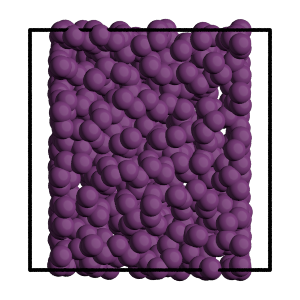

In [14]:
sim_viewer = FresnelGSD(gsd_file="slab_x_interface.gsd", view_axis=(0, 1, 0), frame=-1)
sim_viewer.view()

You can see that particles are not passing through the simulation volume in the x-direction (left/right). In fact, we can see a small amount of space within the simulation volume along that direction where particles can't access, this is because of the repulsive force caused by the wall.

Still, we can better visualize this using the unwrapped particle positions.

**Note**
We'll adjust the height paramter to zoom out our view since the particle positions are outside the simulation volume

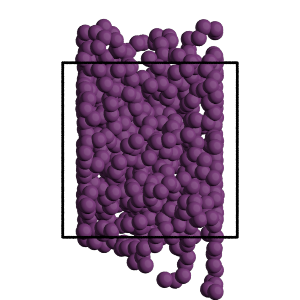

In [15]:
sim_viewer.unwrap_positions = True
sim_viewer.height += 3
sim_viewer.view()

### Step 2: Creating an interface from the slab

Now that the slab simulation is finished, we will use the final structure as the input to create an interface system. This system initialization step differs from those in `hoomd_organics.base.system` where the inputs are molecules, number of molecules, forcefield, etc. The welding module has its own class (`hoomd_organics.modules.welding.Interface`) desiged to create interfaces from slab simulation GSD files. The `Interface` class creates a new `gsd.hoomd.Snapshot` where the slab system is duplicated and translated along the interface axis.

If we look at the details of the new system we'll notice a couple things:
1. The number of particles has doubled, from 720 to 1440
2. The box lengths along the interface axis are doubled while the other two box lengths remain the same

In [37]:
interface = Interface(gsd_file="slab_x_interface.gsd", interface_axis=(1, 0, 0), gap=0.05)

print(type(interface.hoomd_snapshot))
print("Slab number of particles:", system.n_particles)
print("Interface number of particles:", interface.hoomd_snapshot.particles.N)
print()
print("Slab box lengths:", sim.box_lengths_reduced)
print("Interface box lengths:", interface.hoomd_snapshot.configuration.box[:3])

<class 'gsd.hoomd.Snapshot'>
Slab number of particles: 720
Interface number of particles: 1440

Slab box lengths: [6.39847638 6.39847638 6.39847638]
Interface box lengths: [11.846953   6.3984766  6.3984766]


### Step 3: Running a welding simulation



The hoomd forcefield was initially created in the `hoomd_organics.base.System` class. However, since the interface system is not initalized in the same way, we can reuse the hoomd forces we saved (by using `Simulation.pickle_forcefield()`) and pass it directly in this simulation instance.

In [38]:
with open("forcefield.pickle", "rb") as f:
    hoomd_forces = pickle.load(f)

print(hoomd_forces)

[<hoomd.md.pair.pair.LJ object at 0x1af5a1d60>, <hoomd.md.special_pair.LJ object at 0x1af5b2b50>, <hoomd.md.bond.Harmonic object at 0x1af5b20d0>, <hoomd.md.angle.Harmonic object at 0x1aeedb520>, <hoomd.md.dihedral.OPLS object at 0x1aeedb100>]


In [39]:
weld_sim = WeldSimulation(initial_state=interface.hoomd_snapshot, forcefield=hoomd_forces, gsd_file_name="weld.gsd")

Initializing simulation state from a snapshot.


Similar to `SlabSimulation` the `WeldSimulaton` class also adds walls along the simulation axis. This is because we only want diffusion and mixing to occur along one direction of the interface.

In [40]:
weld_sim.forces

In [41]:
for wall in weld_sim.forces[-1].walls:
    print(wall)
print()
print("Simulation volume:", weld_sim.box_lengths_reduced)

Plane(origin=_HOOMDTuple(5.923476696014404, 0.0, 0.0), normal=_HOOMDTuple(-1.0, 0.0, 0.0), 
Plane(origin=_HOOMDTuple(-5.923476696014404, -0.0, -0.0), normal=_HOOMDTuple(1.0, 0.0, 0.0), 

Simulation volume: [11.84695339  6.3984766   6.3984766 ]


In [42]:
weld_sim.run_NVT(kT=10.0, n_steps=3e4, tau_kt=0.001)

Step 5500 of 30000; TPS: 322.46; ETA: 1.3 minutes
Step 11000 of 30000; TPS: 327.58; ETA: 1.0 minutes
Step 16500 of 30000; TPS: 329.2; ETA: 0.7 minutes
Step 22000 of 30000; TPS: 330.17; ETA: 0.4 minutes
Step 27500 of 30000; TPS: 330.46; ETA: 0.1 minutes


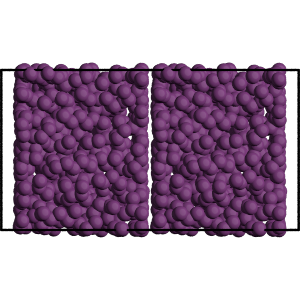

In [30]:
sim_viewer = FresnelGSD(gsd_file="weld.gsd", view_axis=(0, 1, 0), frame=0, height=12)
sim_viewer.view()

In [33]:
sim_viewer.colors

array([0.5 , 0.25, 0.5 ])

In [ ]:
sim_viewer.colors

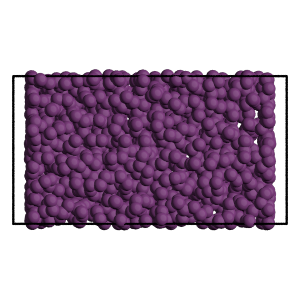

In [43]:
sim_viewer.frame = -1
sim_viewer.height = 13
sim_viewer.view()